# Lab 2. Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [164]:
import string
import os
import torch
import torch.nn as nn
import numpy as np
from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Data handling

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [22]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [79]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2024-08-22 19:14:23--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.4’

onegin.txt.4        100%[===================>] 256.37K  1.29MB/s    in 0.2s    

2024-08-22 19:14:24 (1.29 MB/s) - ‘onegin.txt.4’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [80]:
lines_len = list()
for line in text:
    lines_len.append(len(line))
print(np.mean(lines_len))

20.018058690744923


In [84]:
len(text)

7088

In [85]:
text = np.array(text)

In [90]:
# Split the dataset (lines) on train/validation sets
train_valid_test_ratios = [0.8, 0.1, 0.1]

n_total_lines = len(text)
n_train_lines = round(train_valid_test_ratios[0] * n_total_lines)
n_valid_lines = round(train_valid_test_ratios[1] * n_total_lines)
n_test_lines = n_total_lines - n_train_lines - n_valid_lines

indices = np.arange(n_total_lines)
np.random.shuffle(indices)

train_indices = indices[:n_train_lines]
valid_indices = indices[n_train_lines:n_train_lines + n_valid_lines]
test_indices = indices[n_train_lines + n_valid_lines:]

train_text = text[train_indices]
valid_text = text[valid_indices]
test_text = text[test_indices]

In [91]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
train_text = ''.join(train_text).lower()
valid_text = ''.join(valid_text).lower()
test_text = ''.join(test_text).lower()

In [92]:
len(train_text), len(valid_text), len(test_text)

(113519, 14064, 14305)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [93]:
len(set(train_text)), len(set(valid_text)), len(set(test_text))

(83, 54, 70)

In [97]:
tokens = sorted(set(''.join(text).lower()))

In [98]:
len(tokens), type(tokens)

(83, list)

Number of tokens in train dataset is 83 (the number of token in all text), so we good

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [99]:
# dict <index>:<char>
# Your great code here
token_to_idx = {idx: token for token, idx in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {token: idx for token, idx in enumerate(tokens)}

In [217]:
# Convert texts to indices
train_text_indices = np.array([token_to_idx[char] for char in train_text])
valid_text_indices = np.array([token_to_idx[char] for char in valid_text])
test_text_indices = np.array([token_to_idx[char] for char in test_text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

We have 83 tokens, so i this it's better to calculate the embedding (maybe a size of 50)

In [235]:
from tqdm.notebook import trange

def char_rnn_data_generator(text_indices, seq_length, batch_size):
    # Calculate the number of complete batches per epoch
    num_batches = (len(text_indices) - seq_length) // batch_size
    
    # Shuffle the indices at the beginning of each epoch
    start_indices = np.random.permutation(len(text_indices) - seq_length)
    
    for batch_num in trange(num_batches):
        batch_start_indices = start_indices[batch_num * batch_size:(batch_num + 1) * batch_size]

        batch_inputs = np.zeros((batch_size, seq_length), dtype=np.int32)

        for i, start_idx in enumerate(batch_start_indices):
            batch_inputs[i] = text_indices[start_idx:start_idx + seq_length]
            
        yield batch_inputs
    
    # Handle any remaining data that wasn't covered by the above loop
    remainder = len(text_indices) - seq_length - num_batches * batch_size
    if remainder > 0:
        batch_start_indices = start_indices[-remainder:]

        # If remainder < batch_size, create smaller batch
        remainder_batch_size = min(batch_size, remainder)
        batch_inputs = np.zeros((remainder_batch_size, seq_length), dtype=np.int32)

        for i, start_idx in enumerate(batch_start_indices):
            batch_inputs[i] = text_indices[start_idx:start_idx + seq_length]

        yield batch_inputs


## Vanilla RNN

In [220]:
model_params = {
    'n_tokens' : len(tokens),
    'n_embedding': 32,
    'n_hidden': 64,
    'length_of_input': 32
}

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [221]:
class VanillaRNN(nn.Module):
    def __init__(self, 
                 num_tokens=model_params['n_tokens'], 
                 embedding_size=model_params['n_embedding'], 
                 rnn_num_units=model_params['n_hidden']):
        super().__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(rnn_num_units + embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([h_prev, x_emb], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [222]:
vanilla_rnn = VanillaRNN()

In [223]:
def rnn_loop(rnn, batch):
    '''
    batch: batch_size x num_tokens
    '''
    hid_state = rnn.initial_state(batch.size()[0])
    logits = []
    
    for x in batch.transpose(0, 1):
        hid_state, logits_next = rnn(x, hid_state)
        logits.append(logits_next)
    
    return torch.stack(logits, dim=1)

### Testing the batching function

In [236]:
generator = char_rnn_data_generator(train_text_indices, model_params['length_of_input'], 128)

In [237]:
inputs = next(generator)
inputs = torch.tensor(inputs, dtype=torch.int64)
logit_seq = rnn_loop(vanilla_rnn, inputs)

  0%|          | 0/886 [00:00<?, ?it/s]

In [238]:
loss_func = nn.CrossEntropyLoss()
loss = loss_func(logit_seq[:, :-1].reshape((-1, model_params['n_tokens'])), inputs[:, 1:].reshape(-1))

In [239]:
loss.backward()

In [240]:
for w in vanilla_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### Training

In [208]:
model = VanillaRNN()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [242]:
training_params = {
    'n_epochs': 5,
    'train_batch_size': 128,
    'valid_batch_size': 128
    }

In [243]:
loss_history = {'train': [], 'validation': []}

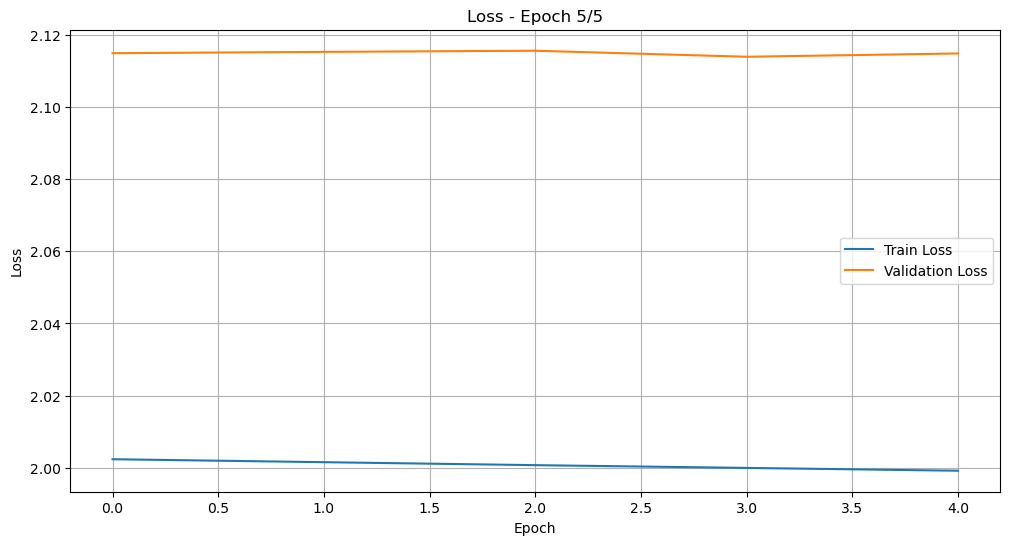

Epoch 5/5: Train Loss = 1.9992, Validation Loss = 2.1149


In [244]:
for epoch in range(training_params['n_epochs']):
    train_generator = char_rnn_data_generator(train_text_indices,
                                          model_params['length_of_input'],
                                          training_params['train_batch_size'])
    valid_generator = char_rnn_data_generator(valid_text_indices,
                                            model_params['length_of_input'],
                                            training_params['valid_batch_size'])
    train_loss_batch = []

    train_progress_bar = tqdm(train_generator, desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Training", leave=False)

    for inputs in train_progress_bar:
        inputs = torch.tensor(inputs, dtype=torch.int64)
        logit_seq = rnn_loop(model, inputs)
        loss = loss_func(logit_seq[:, :-1].reshape((-1, model_params['n_tokens'])), inputs[:, 1:].reshape(-1))
        train_loss_batch.append(loss.detach().cpu().numpy() * inputs.size()[0])

        loss.backward()
        opt.step()
        opt.zero_grad()

    avg_train_loss = np.sum(train_loss_batch) / len(train_text)
    loss_history['train'].append(avg_train_loss)

    val_loss_batch = []

    with torch.no_grad():
        val_progress_bar = tqdm(valid_generator, desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Validation", leave=False)

        for inputs in val_progress_bar:
            inputs = torch.tensor(inputs, dtype=torch.int64)
            logit_seq = rnn_loop(model, inputs)
            loss = loss_func(logit_seq[:, :-1].reshape((-1, model_params['n_tokens'])), inputs[:, 1:].reshape(-1))
            val_loss_batch.append(loss.detach().cpu().numpy() * inputs.size()[0])

    avg_val_loss = np.sum(val_loss_batch) / len(valid_text)
    loss_history['validation'].append(avg_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history['train'], label='Train Loss')
    plt.plot(loss_history['validation'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss - Epoch {epoch + 1}/{training_params["n_epochs"]}')
    plt.legend()
    plt.grid(True)

    plt.show()

    print(f"Epoch {epoch + 1}/{training_params['n_epochs']}: "
          f"Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")

### Evaluate on a test text

In [245]:
test_generator = char_rnn_data_generator(test_text_indices,
                                        model_params['length_of_input'],
                                        batch_size=256)
test_loss_batch = []
with torch.no_grad():
    test_progress_bar = tqdm(test_generator, desc=f"Testing", leave=False)

    for inputs in test_progress_bar:
        inputs = torch.tensor(inputs, dtype=torch.int64)
        logit_seq = rnn_loop(model, inputs)
        loss = loss_func(logit_seq[:, :-1].reshape((-1, model_params['n_tokens'])), inputs[:, 1:].reshape(-1))
        test_loss_batch.append(loss.detach().cpu().numpy() * inputs.size()[0])

avg_test_loss = np.sum(test_loss_batch) / len(test_text)
print(f'Test Loss = {avg_test_loss:.4f}')

Testing: 0it [00:00, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Test Loss = 2.1410


### Text generation

In [173]:
def generate_sample(model, seed_phrase='Евгений', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, i], hid_state)
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = model(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [253]:
# An example of generated text.
print(generate_sample(model, seed_phrase='Евгений', max_length=500, temperature=0.7))

евгений

но и не мне оно ты, о нем сыпить он он ветьком запел.
татьяна гред не молин успож глабим, не с на забавлющик они судьби своей не тайный жля брание важный сведан,
к своей межник судьбой предсон с оставав и сталой.
был состель за новещая, стах он ином и своей небещит и онегин вашей соглась.
с славит пред едусь без ног он усыма нуши гладила, красавая сердцу на сердце романова,
такой образай об не пргала!

моей обпостанькой и все был заблит доледь закачал утрича,
примечать дам двора,
на сле


### Saving best model

In [247]:
def save_checkpoint(model, optimizer, epoch, loss_history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }
    torch.save(checkpoint, path)

In [248]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    return epoch, loss_history

In [252]:
rnn_checkpoint = 'models/rnn_checkpoint.pth'
save_checkpoint(model, opt, None, None, rnn_checkpoint)

## LSTM

Let's use LSTM instead of vanilla RNN and compare the results.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text.

In [4]:
# Saving and loading code here

## References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>